In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, schedule, execute, execute_function
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

import pandas as pd

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.library.calibration.rough_frequency import RoughFrequencyCal
from qiskit_experiments.library.calibration.frequency_cal import FrequencyCal
from qiskit_experiments.library.calibration.fine_frequency_cal import FineFrequencyCal

from qiskit_experiments.calibration_management.calibrations import Calibrations

from qiskit.tools.monitor import job_monitor

import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

from qiskit import transpile, schedule as build_schedule
from qiskit.pulse import Schedule, Play, SetFrequency, Drag, Gaussian, ShiftFrequency, GaussianSquare, DriveChannel, ControlChannel, Waveform, ScheduleBlock, Acquire, AcquireChannel, MemorySlot, MeasureChannel, Delay
from qiskit.circuit import QuantumRegister, ClassicalRegister

from qiskit.circuit import Instruction

# based on https://stackoverflow.com/questions/49503869/attributeerror-while-trying-to-load-the-pickled-matplotlib-figure
def show_figure(fig):
    dummy = plt.figure()
    new_manager = dummy.canvas.manager
    new_manager.canvas.figure = fig
    fig.set_canvas(new_manager.canvas)
    
# based on https://www.delftstack.com/howto/python/parallel-for-loops-python/
import asyncio
import time

def background(f):
    def wrapped(*args, **kwargs):
        return asyncio.get_event_loop().run_in_executor(None, f, *args, **kwargs)
    return wrapped

d = lambda idx: pulse.DriveChannel(idx)
m = lambda idx: pulse.MeasureChannel(idx)
u = lambda idx: pulse.ControlChannel(idx)
a = lambda idx: pulse.AcquireChannel(idx)

provider = IBMQ.get_provider(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')
backend = provider.get_backend('ibmq_casablanca')
# backend = provider.get_backend('ibmq_jakarta')
# backend = QasmSimulator.from_backend(backend)

# provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
# backend = provider.get_backend('ibmq_armonk')

# configuration - Hardware configuration information.
config = backend.configuration()
# properties - Physical properties of the device.
properties = backend.properties()
# defaults - Information for pulse properties that change frequently.
defaults = backend.defaults()

import matplotlib
import matplotlib.pyplot as plt

import random
import numpy as np
import matplotlib.pyplot as plt

from qiskit.opflow import Zero, One, I, X, Y, Z

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, execute, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter, Gate

from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import time

from qiskit import schedule

from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho, RZXCalibrationBuilder

import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import XGate, YGate, SXGate, RZGate
from qiskit.transpiler import PassManager, InstructionDurations
from qiskit.transpiler.passes import ALAPSchedule, ASAPSchedule, DynamicalDecoupling
from qiskit.visualization import timeline_drawer

from qiskit.transpiler.passes import RZXCalibrationBuilderNoEcho, RZXCalibrationBuilder
from qiskit.visualization.pulse_v2 import draw, IQXDebugging

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
backend = QasmSimulator.from_backend(provider.get_backend("ibmq_jakarta"))

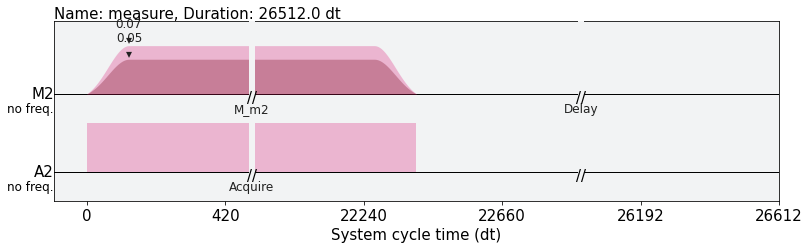

In [2]:
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

def measurement_cal(qubit, duration=None, amp_mul=None):
    def_meas_cal = defaults.instruction_schedule_map.get('measure', qubit)
    # print(def_meas_cal)
    amp_, sigma_, width_, duration_, mes_ch_ = None, None, None, None, None
    # x_amp_, x_beta_, x_sigma_, x_duration_, x_dr_ch_ = None, None, None, None, None
    for instr_ in def_meas_cal.instructions:
        # print(instr_)
        if isinstance(instr_[1], pulse.instructions.play.Play):
            if isinstance(instr_[1].operands[0], pulse.GaussianSquare):
                if isinstance(instr_[1].channel, pulse.channels.MeasureChannel):
                    amp_ = instr_[1].operands[0].amp
                    sigma_ = instr_[1].operands[0].sigma
                    duration_ = instr_[1].operands[0].duration
                    width_ = instr_[1].operands[0].width
                    mes_ch_ = instr_[1].channel.index
                    
    if duration is not None:
        duration = get_closest_multiple_of_16(duration)
        width_ = duration/duration_ * width_
        duration_ = duration
        
    if amp_mul is not None:
        amp_ *= amp_mul
        
    # print(amp_, sigma_, width_, duration_, mes_ch_)
    # print(duration_)
    
    meas_cal = Schedule((0, Acquire(duration_, AcquireChannel(mes_ch_), MemorySlot(mes_ch_))), 
                        (0, Play(GaussianSquare(duration=duration_, amp=amp_, sigma=sigma_, width=width_, name='M_m2'), MeasureChannel(mes_ch_), name='M_m'+str(mes_ch_))), 
                        (duration_, Delay(4112, MeasureChannel(mes_ch_))), name="measure")
    
    # print(meas_cal)
    return meas_cal
                    
measurement_cal(2, duration=22400, amp_mul=1.0).draw(style=IQXDebugging())


In [2]:
def measurement_circuit(qubits, final_state, delay=None):
    qc = QuantumCircuit(backend.configuration().n_qubits, len(qubits))
    if final_state == 'ext':
        qc.x(qubits)
    if delay is not None:
        qc.delay(delay, qubits)
    qc.measure(qubits, list(range(len(qubits))))
    return qc

# qc_ = measurement_circuit([1], 'ext', delay=400, duration=22400+10*16)
# schedule_ = build_schedule(qc_, backend, method='alap')
# schedule_ += measurement_cal(1, duration=22400+10*16)
# print(schedule_)

In [11]:
qc_gnd = measurement_circuit([1,3,5], final_state='gnd')
qc_ext = measurement_circuit([1,3,5], final_state='ext')
jobs = []
circuits = []

# for qc in [qc_gnd, qc_ext]:
#     # schedule = build_schedule([qc_gnd, qc_ext], backend)
job = execute([qc_gnd, qc_ext], backend, meas_level=1, meas_return='single', memory=True, shots=30000, optimization_level=0)
circuits.append(qc)
job_monitor(job)
jobs.append(job)

Job Status: job has successfully run


<Figure size 432x288 with 0 Axes>

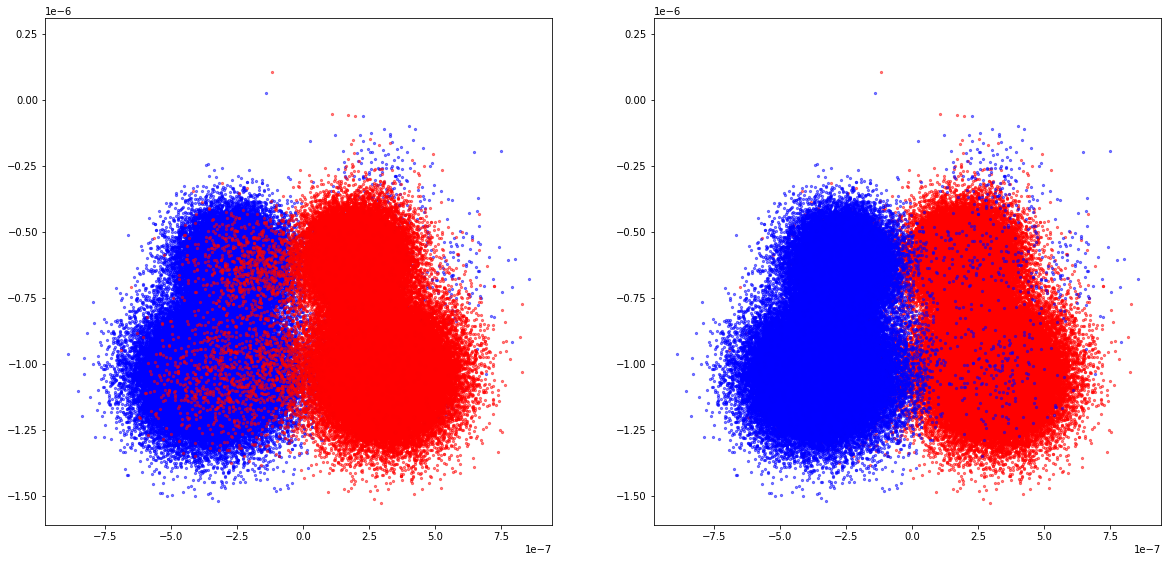

In [25]:
scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


In [26]:
# default qiskit discriminator

jobs = []
circuits = []
qubits = [1,3,5]

experiments = [
    {'duration': 22400, 'amp_mul': 1.0, 'qubits': [1]}
]

for exp in experiments:        
    qc_gnd = measurement_circuit(exp['qubits'], final_state='gnd', delay=0)
    qc_ext = measurement_circuit(exp['qubits'], final_state='ext', delay=0)
    qc_gnd.measure([1],[0])
    qc_ext.measure([1],[0])

    job = execute([qc_gnd, qc_ext], backend, meas_level=2, meas_return='single', memory=True, shots=30000, optimization_level=0)
    circuits.append([qc_gnd, qc_ext])
    job_monitor(job)
    jobs.append(job)

Job Status: job has successfully run


In [27]:
# default qiskit discriminator
total = 60000.0
correct = 0.0
for job in jobs:
    gnd_results = job.result().get_memory(0)
    exc_results = job.result().get_memory(1)
    for res in gnd_results:
        if res == '0':
            correct += 1
    for res in exc_results:
        if res == '1':
            correct += 1
    score = correct / total
    print("score:", correct, '/', total, '=', score)

score: 58111.0 / 60000.0 = 0.9685166666666667


In [14]:
from qiskit.ignis.measurement import SklearnIQDiscriminator

def add_measurement_cal(schedule_qc, amp_mul=None, discriminators=None):
    if amp_mul is None:
        measurement_amp_mult = [1.6, 2.8, 2.8, 2.4, 2.8, 2.8, 1.2]
    else:
        measurement_amp_mult = [amp_mul]*7
        
    if discriminators is not None:
        measurement_amp_mult = []
        for discr in discriminators:
            measurement_amp_mult.append(discr['settings']['amp_mul'])
    
    schedule_qc_ = []
    for sched_ in schedule_qc:
        new_sched_ = Schedule.initialize_from(sched_)
        for time, inst in sched_.children:
            if isinstance(inst.channels[0], AcquireChannel):
                # print(inst.children)
                new_acquire_sched_ = Schedule()
                for time_, inst_ in inst.children[1][1].children:
                # for time_, inst_ in inst.children:
                    if isinstance(inst_.channels[0], MeasureChannel) and isinstance(inst_, pulse.instructions.play.Play):
                        new_acquire_sched_.insert(time_, Play(GaussianSquare(duration=inst_.operands[0].duration, 
                                                                            amp=inst_.operands[0].amp * measurement_amp_mult[inst_.channel.index], # <-----
                                                                            sigma=inst_.operands[0].sigma, 
                                                                            width=inst_.operands[0].width, 
                                                                            name=inst_.operands[0].name), 
                                                             MeasureChannel(inst_.channel.index), name=inst_.name), inplace=True)
                    else:
                        if isinstance(inst_, Acquire):
                            aq_idx = inst_.channels[0].index
                            if discriminators is not None:
                                if discriminators[aq_idx] is not None:
                                    discriminator = discriminators[aq_idx]['discriminator']
                                    discriminator.name = "quadratic_discriminator"
                                    discriminator.params = {}
                                    new_acquire_sched_.insert(time_, Acquire(inst_.operands[0], AcquireChannel(aq_idx), MemorySlot(inst_.operands[2].index), discriminator=discriminator), inplace=True)
                                    # print(Acquire(inst_.operands[0], AcquireChannel(aq_idx), MemorySlot(inst_.operands[2].index), discriminator=discriminator))
                                else:
                                    new_acquire_sched_.insert(time_, inst_, inplace=True)
                            else:
                                new_acquire_sched_.insert(time_, inst_, inplace=True)
                        else:
                            new_acquire_sched_.insert(time_, inst_, inplace=True)
                new_sched_.insert(time, new_acquire_sched_, inplace=True)
                
            else:
                new_sched_.insert(time, inst, inplace=True)
    
        # for instr_ in sched_.instructions:
        #     if isinstance(instr_[1].channel, MeasureChannel) and isinstance(instr_[1], pulse.instructions.play.Play):
        #         print(instr_)
        # print("--------")
        # for instr_ in new_sched_.instructions:
        #     if isinstance(instr_[1].channel, MeasureChannel) and isinstance(instr_[1], pulse.instructions.play.Play):
        #         print(instr_)
    
        # show_figure(sched_.draw(style=IQXDebugging(), time_range=[32000, 50000]))
        # show_figure(new_sched_.draw(style=IQXDebugging(), time_range=[32000, 50000]))
        # break
        schedule_qc_.append(new_sched_)
    return schedule_qc_

# add_measurement_cal([schedules[-1][1]], discriminators=[None, discriminator1, None,None,None,None,None])

# qc_ext = measurement_circuit(exp['qubits'], final_state='ext', delay=0)
# schedule_ext = build_schedule(qc_ext, backend, method='alap')
# schedule_ext = add_measurement_cal([schedule_ext], amp_mul=exp['amp_mul'])[0]

In [4]:
jobs_discriminator = []
circuits_discriminator = []
schedules_discriminator = []
qubits = [0,1,2,3,4,5,6]
scale_factor = 1e-14

experiments = [
    {'duration': 22400, 'amp_mul': 1.0, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 1.2, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 1.4, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 1.6, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 1.8, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 2.0, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 2.2, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 2.4, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 2.6, 'qubits': qubits},
    {'duration': 22400, 'amp_mul': 2.8, 'qubits': qubits},
]

for exp in experiments:
    qc_gnd = measurement_circuit(exp['qubits'], final_state='gnd', delay=0)
    qc_ext = measurement_circuit(exp['qubits'], final_state='ext', delay=0)
    
    schedule_gnd = build_schedule(qc_gnd, backend, method='alap')
    schedule_gnd = add_measurement_cal([schedule_gnd], amp_mul=exp['amp_mul'])[0]
    
    schedule_ext = build_schedule(qc_ext, backend, method='alap')
    schedule_ext = add_measurement_cal([schedule_ext], amp_mul=exp['amp_mul'])[0]

    job = execute([schedule_gnd, schedule_ext]*4, backend, meas_level=1, meas_return='single', memory=True, shots=30000, optimization_level=0) #, default_meas_los=meas_los_freq)
    circuits_discriminator.append([qc_gnd, qc_ext]*4)
    schedules_discriminator.append([schedule_gnd, schedule_ext]*4)
    job_monitor(job)
    jobs_discriminator.append(job)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [10]:
# len(schedules_discriminator[0][:1])

1

Qubit:  0
Qubit:  1
Qubit:  2
Qubit:  3
Qubit:  4
Qubit:  5
Qubit:  6
0 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7ffaa2f04fd0>, 'score': 0.9817791666666666, 'settings': {'duration': 22400, 'amp_mul': 2.2, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
1 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7ff9eee41940>, 'score': 0.984375, 'settings': {'duration': 22400, 'amp_mul': 2.2, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
2 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7ffaa2e14ac0>, 'score': 0.9910458333333333, 'settings': {'duration': 22400, 'amp_mul': 2.8, 'qubits': [0, 1, 2, 3, 4, 5, 6]}}
3 {'discriminator': <qiskit.ignis.measurement.discriminator.iq_discriminators.SklearnIQDiscriminator object at 0x7ff9eeb0e820>, 'score': 0.9902, 'settings': {'duration': 22400, 'amp_mul': 2.2, 'qubits': [0, 1, 2, 3, 4, 5, 6

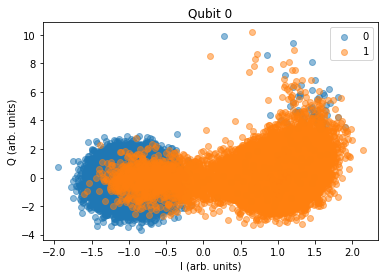

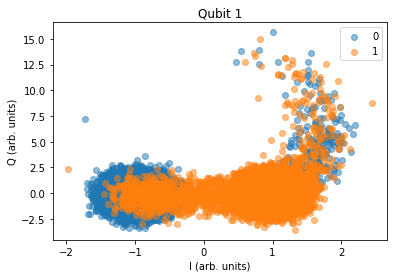

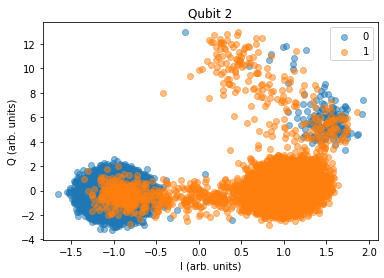

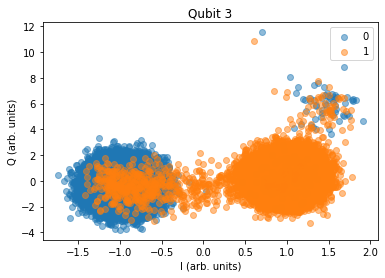

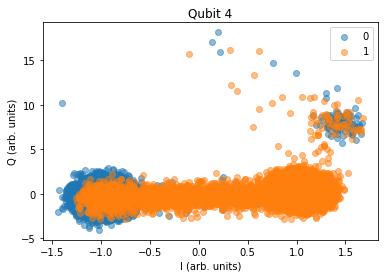

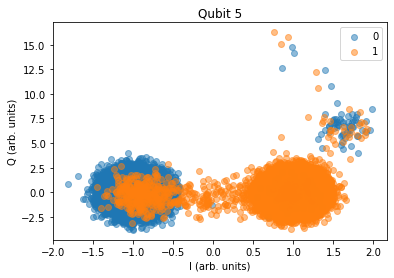

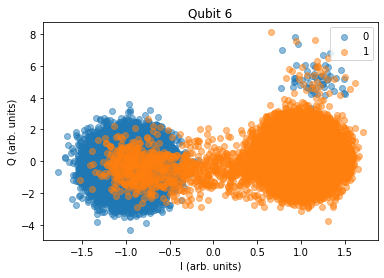

In [17]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from qiskit.ignis.measurement import SklearnIQDiscriminator, QuadraticIQDiscriminator

discriminators = []
display_fig = False

for qubit_idx in qubits:
    print("Qubit: ", qubits[qubit_idx])

    best_score = 0
    best_settings = None
    discriminator = None

    for job_idx, job in enumerate(jobs_discriminator):
        gnd_results = job.result().get_memory(0)[:, qubit_idx]*scale_factor
        exc_results = job.result().get_memory(1)[:, qubit_idx]*scale_factor
        for circ_idx in range(1,4):
            gnd_results = np.concatenate([gnd_results, job.result().get_memory(circ_idx*2 + 0)[:, qubit_idx]*scale_factor])
            exc_results = np.concatenate([exc_results, job.result().get_memory(circ_idx*2 + 1)[:, qubit_idx]*scale_factor])

        gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
        exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])

        x = np.concatenate([gnd_results, exc_results])
        y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
        
        classifier = KNeighborsClassifier(100)
        classifier.fit(x,y)
        score = classifier.score(x, y)

        if score > best_score:
            if display_fig:
                plt.figure()
                fig, axs = plt.subplots(1, 2, figsize=(10, 10))
                axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[0].axis('square')

                axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
                axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
                axs[1].axis('square')

                x_min, x_max = x[:, 0].min(), x[:, 0].max()
                y_min, y_max = x[:, 1].min(), x[:, 1].max()
                xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))

                if hasattr(classifier, "decision_function"):
                    Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
                else:
                    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
                Z = Z.reshape(xx.shape)
                axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
                plt.show()
        
            best_score = score
            best_settings = experiments[job_idx]
            # print(experiments[job_idx])
            # print(score)
            discriminator = SklearnIQDiscriminator(KNeighborsClassifier(100), job.result(), [qubit_idx], expected_states=[0,1], standardize=True, schedules=schedules_discriminator[job_idx][:2])
            # discriminator = QuadraticIQDiscriminator(job.result(), [qubit_idx], expected_states=[0,1], standardize=True, schedules=schedules_discriminator[job_idx])

    discriminators.append({'discriminator': discriminator, 'score': best_score, 'settings': best_settings})
    
for qubit in qubits:
    discriminators[qubit]['discriminator'].plot()
    print(qubit, discriminators[qubit])

In [18]:
# discriminator check
jobs = []
circuits = []
schedules = []
scale_factor = 1e-14

for qubit in qubits:
    qc_gnd = measurement_circuit([qubit], final_state='gnd', delay=0)
    qc_ext = measurement_circuit([qubit], final_state='ext', delay=0)

    schedule_gnd = build_schedule(qc_gnd, backend, method='alap')
    schedule_gnd = add_measurement_cal([schedule_gnd], discriminators=discriminators)[0]

    schedule_ext = build_schedule(qc_ext, backend, method='alap')
    schedule_ext = add_measurement_cal([schedule_ext], discriminators=discriminators)[0]

    job = execute([schedule_gnd, schedule_ext], backend, meas_level=2, memory=True, shots=30000, optimization_level=0) #, default_meas_los=meas_los_freq)
    circuits.append([qc_gnd, qc_ext])
    schedules.append([schedule_gnd, schedule_ext])
    job_monitor(job)
    jobs.append(job)

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run


In [19]:
# measurement with custom discriminator - test 2 more training data K-Neigbors(100)
for job_idx, job in enumerate(jobs):
    total = 60000.0
    correct = 0.0
    
    print("Qubit", qubits[job_idx])
    gnd_results = job.result().get_memory(0)
    exc_results = job.result().get_memory(1)
   
    for res in gnd_results:
        if res == '0':
            correct += 1
    for res in exc_results:
        if res == '1':
            correct += 1
    score = correct / total
    print("score:", correct, '/', total, '=', score)

Qubit 0
score: 58581.0 / 60000.0 = 0.97635
Qubit 1
score: 58936.0 / 60000.0 = 0.9822666666666666
Qubit 2
score: 59412.0 / 60000.0 = 0.9902
Qubit 3
score: 59298.0 / 60000.0 = 0.9883
Qubit 4
score: 58496.0 / 60000.0 = 0.9749333333333333
Qubit 5
score: 59386.0 / 60000.0 = 0.9897666666666667
Qubit 6
score: 59246.0 / 60000.0 = 0.9874333333333334


In [16]:
# measurement with custom discriminator - test 2 more training data K-Neigbors(10)
for job_idx, job in enumerate(jobs):
    total = 60000.0
    correct = 0.0
    
    print("Qubit", qubits[job_idx])
    gnd_results = job.result().get_memory(0)
    exc_results = job.result().get_memory(1)
   
    for res in gnd_results:
        if res == '0':
            correct += 1
    for res in exc_results:
        if res == '1':
            correct += 1
    score = correct / total
    print("score:", correct, '/', total, '=', score)

Qubit 0
score: 58685.0 / 60000.0 = 0.9780833333333333
Qubit 1
score: 59055.0 / 60000.0 = 0.98425
Qubit 2
score: 59290.0 / 60000.0 = 0.9881666666666666
Qubit 3
score: 59266.0 / 60000.0 = 0.9877666666666667
Qubit 4
score: 58706.0 / 60000.0 = 0.9784333333333334
Qubit 5
score: 57885.0 / 60000.0 = 0.96475
Qubit 6
score: 59173.0 / 60000.0 = 0.9862166666666666


In [59]:
# measurement with custom discriminator
for job_idx, job in enumerate(jobs):
    total = 60000.0
    correct = 0.0
    
    print("Qubit", qubits[job_idx])
    gnd_results = job.result().get_memory(0)
    exc_results = job.result().get_memory(1)
   
    for res in gnd_results:
        if res == '0':
            correct += 1
    for res in exc_results:
        if res == '1':
            correct += 1
    score = correct / total
    print("score:", correct, '/', total, '=', score)

Qubit 0
score: 58243.0 / 60000.0 = 0.9707166666666667
Qubit 1
score: 59011.0 / 60000.0 = 0.9835166666666667
Qubit 2
score: 59368.0 / 60000.0 = 0.9894666666666667
Qubit 3
score: 59161.0 / 60000.0 = 0.9860166666666667
Qubit 4
score: 58569.0 / 60000.0 = 0.97615
Qubit 5
score: 43775.0 / 60000.0 = 0.7295833333333334
Qubit 6
score: 58456.0 / 60000.0 = 0.9742666666666666


In [61]:
# default qiskit
for job_idx, job in enumerate(jobs):
    total = 60000.0
    correct = 0.0
    
    print("Qubit", qubits[job_idx])
    gnd_results = job.result().get_memory(0)
    exc_results = job.result().get_memory(1)
   
    for res in gnd_results:
        if res == '0':
            correct += 1
    for res in exc_results:
        if res == '1':
            correct += 1
    score = correct / total
    print("score:", correct, '/', total, '=', score)

Qubit 0
score: 57570.0 / 60000.0 = 0.9595
Qubit 1
score: 58104.0 / 60000.0 = 0.9684
Qubit 2
score: 58804.0 / 60000.0 = 0.9800666666666666
Qubit 3
score: 58558.0 / 60000.0 = 0.9759666666666666
Qubit 4
score: 58294.0 / 60000.0 = 0.9715666666666667
Qubit 5
score: 59243.0 / 60000.0 = 0.9873833333333333
Qubit 6
score: 58614.0 / 60000.0 = 0.9769


### Other

{'duration': 22400, 'amp_mul': 1.0, 'qubit': 5}
0.9861


<Figure size 432x288 with 0 Axes>

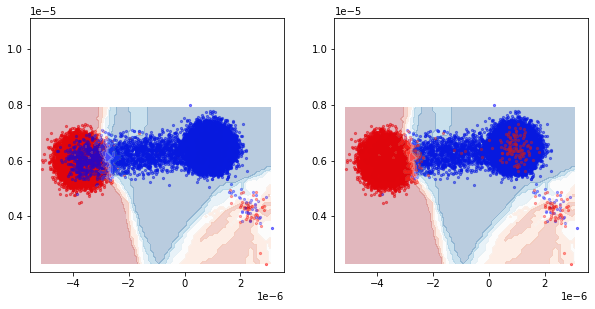

{'duration': 22400, 'amp_mul': 1.2, 'qubit': 5}
0.9870833333333333


<Figure size 432x288 with 0 Axes>

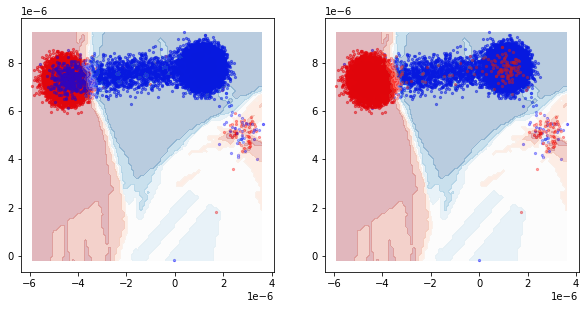

{'duration': 22400, 'amp_mul': 1.4, 'qubit': 5}
0.9873666666666666


<Figure size 432x288 with 0 Axes>

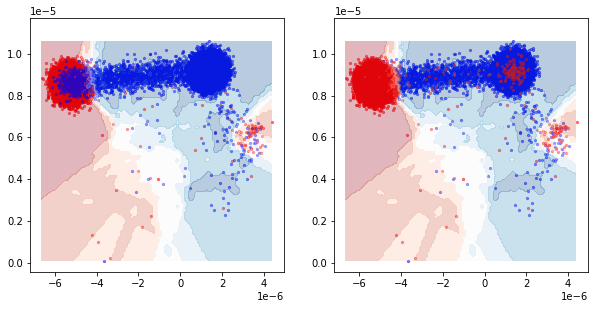

{'duration': 22400, 'amp_mul': 1.6, 'qubit': 5}
0.9868166666666667


<Figure size 432x288 with 0 Axes>

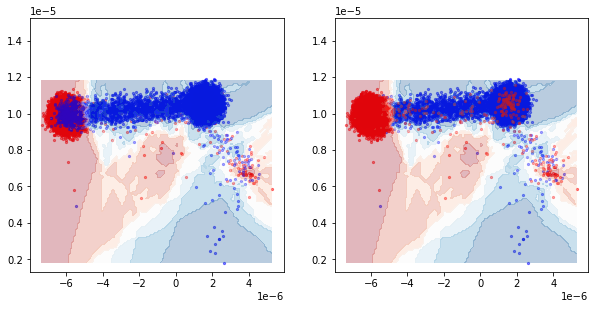

{'duration': 22400, 'amp_mul': 1.8, 'qubit': 5}
0.9879333333333333


<Figure size 432x288 with 0 Axes>

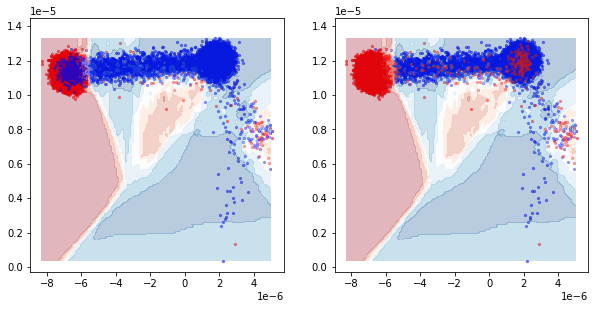

{'duration': 22400, 'amp_mul': 2.0, 'qubit': 5}
0.9858


<Figure size 432x288 with 0 Axes>

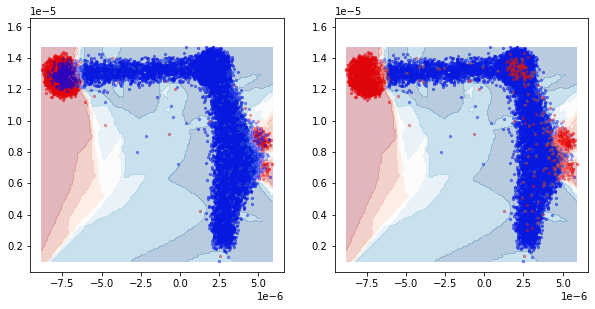

{'duration': 22400, 'amp_mul': 2.2, 'qubit': 5}
0.9845666666666667


<Figure size 432x288 with 0 Axes>

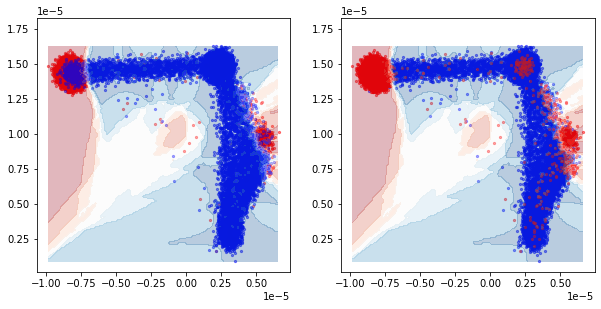

{'duration': 11200, 'amp_mul': 1.0, 'qubit': 5}
0.9868666666666667


<Figure size 432x288 with 0 Axes>

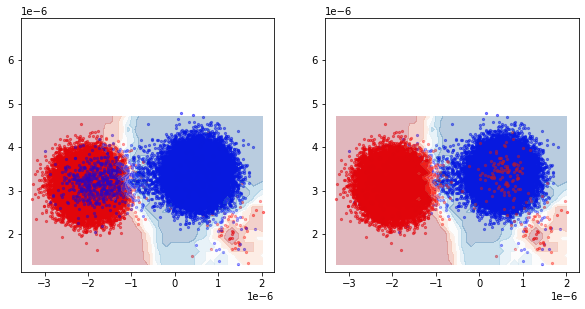

{'duration': 11200, 'amp_mul': 1.2, 'qubit': 5}
0.9868166666666667


<Figure size 432x288 with 0 Axes>

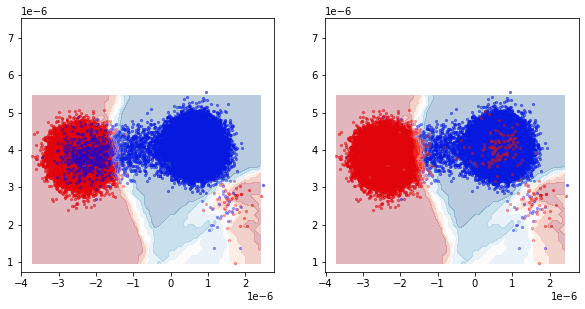

{'duration': 11200, 'amp_mul': 1.4, 'qubit': 5}
0.9888333333333333


<Figure size 432x288 with 0 Axes>

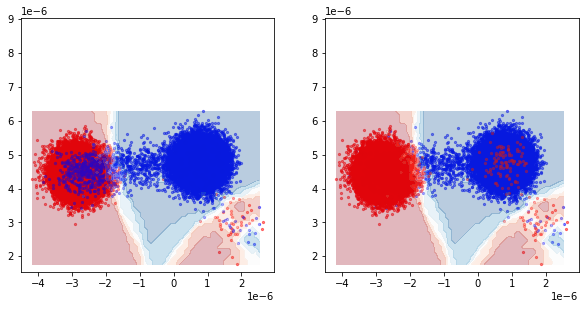

{'duration': 11200, 'amp_mul': 1.6, 'qubit': 5}
0.9888333333333333


<Figure size 432x288 with 0 Axes>

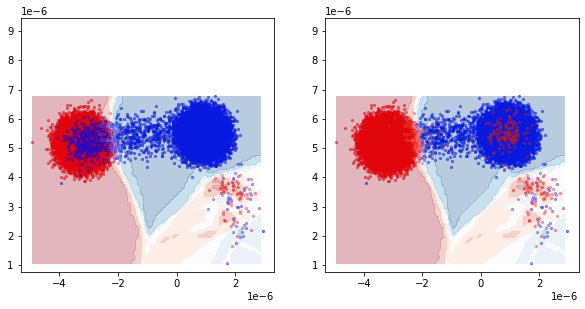

{'duration': 11200, 'amp_mul': 1.8, 'qubit': 5}
0.9899


<Figure size 432x288 with 0 Axes>

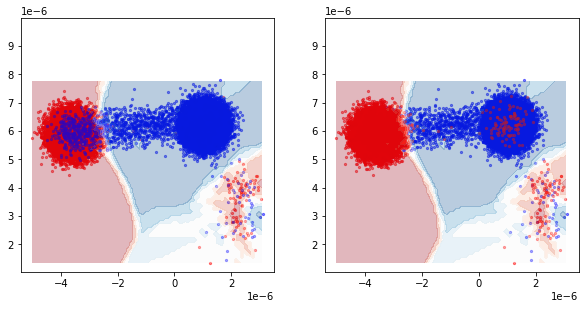

{'duration': 11200, 'amp_mul': 2.0, 'qubit': 5}
0.9893166666666666


<Figure size 432x288 with 0 Axes>

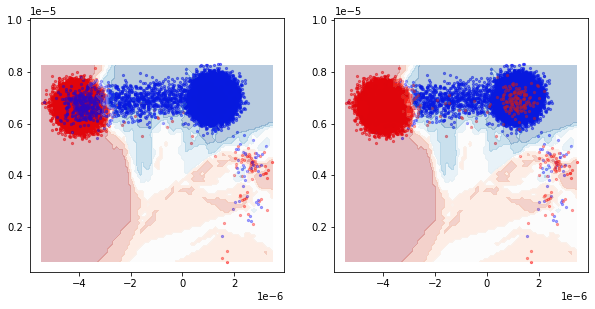

{'duration': 11200, 'amp_mul': 2.2, 'qubit': 5}
0.9872333333333333


<Figure size 432x288 with 0 Axes>

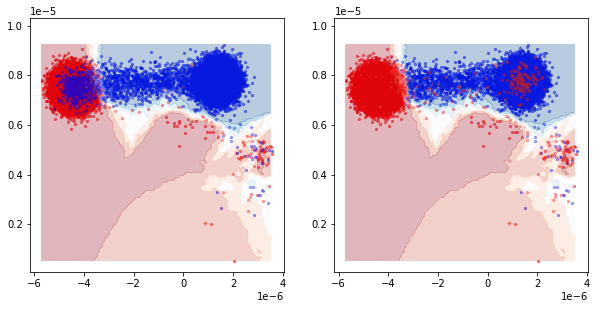

In [307]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

for job_idx, job in enumerate(jobs):
    gnd_results = job.result().get_memory(0)[:,experiments[job_idx]['qubit']]*scale_factor
    exc_results = job.result().get_memory(1)[:,experiments[job_idx]['qubit']]*scale_factor

    gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
    exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])

    x = np.concatenate([gnd_results, exc_results])
    y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[1].axis('square')

    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))

    classifier = KNeighborsClassifier(10)
    classifier.fit(x,y)
    score = classifier.score(x, y)
    print(experiments[job_idx])
    print(score)

    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    plt.show()


{'duration': 22400, 'amp_mul': 1.0, 'qubit': 3}
0.9759


<Figure size 432x288 with 0 Axes>

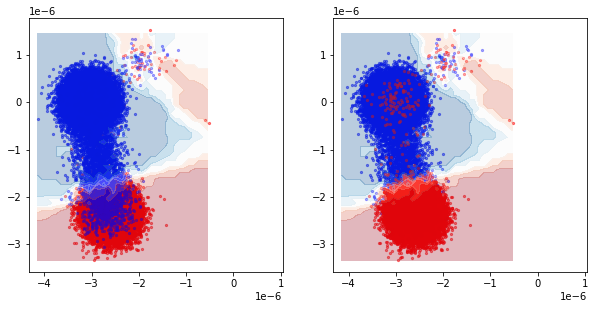

{'duration': 22400, 'amp_mul': 1.2, 'qubit': 3}
0.9749


<Figure size 432x288 with 0 Axes>

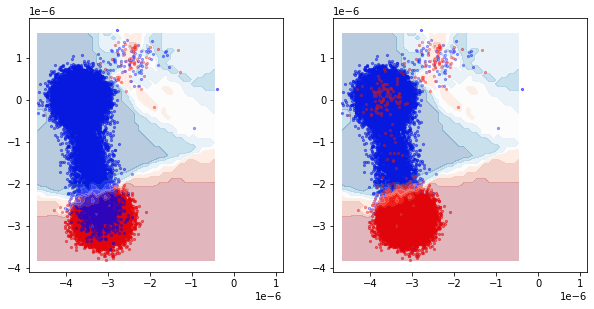

{'duration': 22400, 'amp_mul': 1.4, 'qubit': 3}
0.9806166666666667


<Figure size 432x288 with 0 Axes>

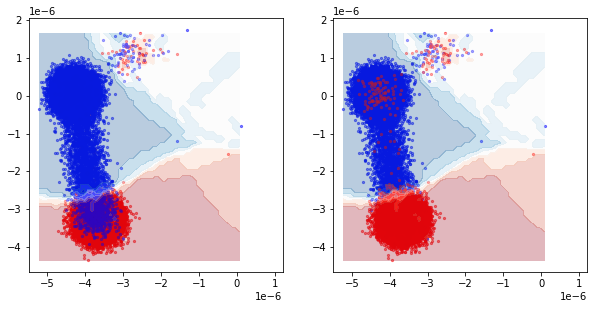

{'duration': 22400, 'amp_mul': 1.6, 'qubit': 3}
0.9825666666666667


<Figure size 432x288 with 0 Axes>

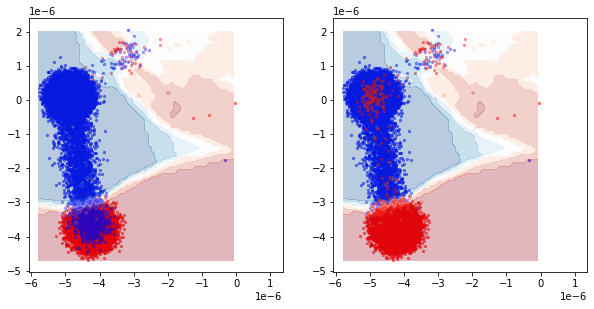

{'duration': 22400, 'amp_mul': 1.8, 'qubit': 3}
0.9848666666666667


<Figure size 432x288 with 0 Axes>

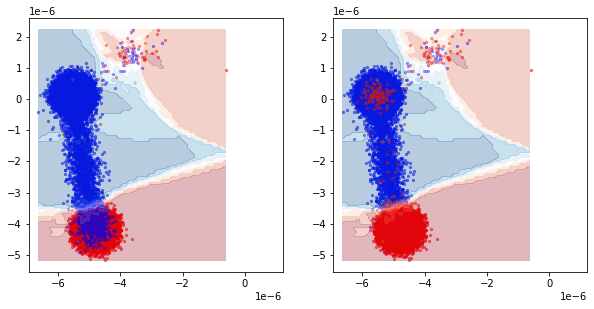

{'duration': 22400, 'amp_mul': 2.0, 'qubit': 3}
0.9866833333333334


<Figure size 432x288 with 0 Axes>

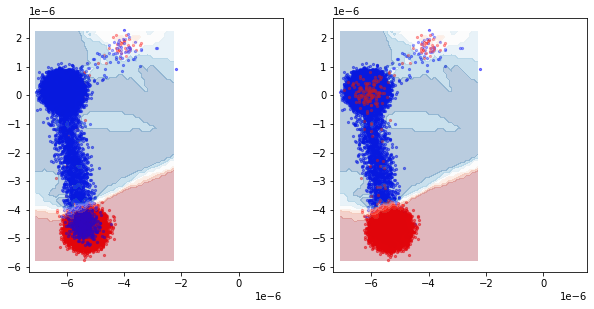

{'duration': 22400, 'amp_mul': 2.2, 'qubit': 3}
0.9872666666666666


<Figure size 432x288 with 0 Axes>

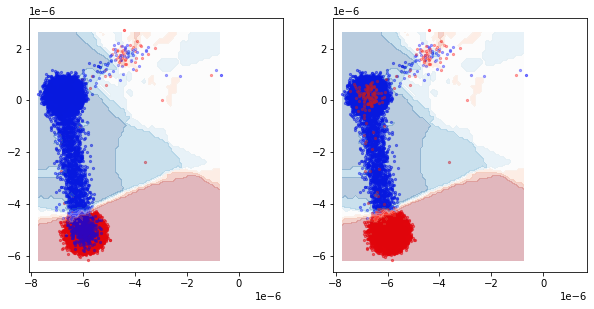

{'duration': 11200, 'amp_mul': 1.0, 'qubit': 3}
0.9746666666666667


<Figure size 432x288 with 0 Axes>

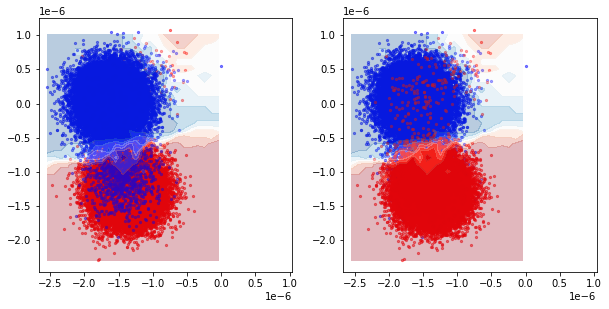

{'duration': 11200, 'amp_mul': 1.2, 'qubit': 3}
0.9762333333333333


<Figure size 432x288 with 0 Axes>

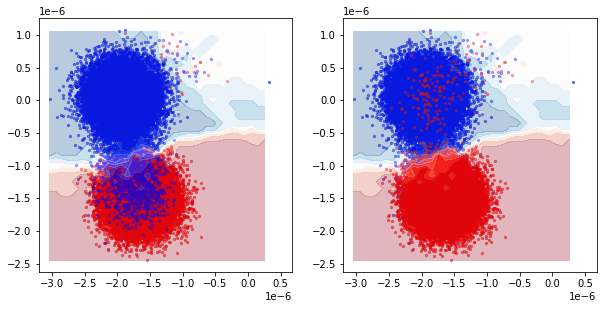

{'duration': 11200, 'amp_mul': 1.4, 'qubit': 3}
0.9800666666666666


<Figure size 432x288 with 0 Axes>

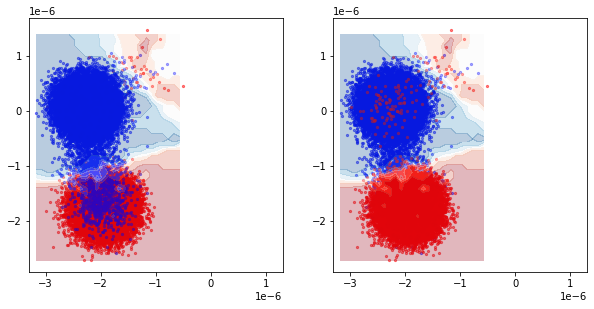

{'duration': 11200, 'amp_mul': 1.6, 'qubit': 3}
0.98365


<Figure size 432x288 with 0 Axes>

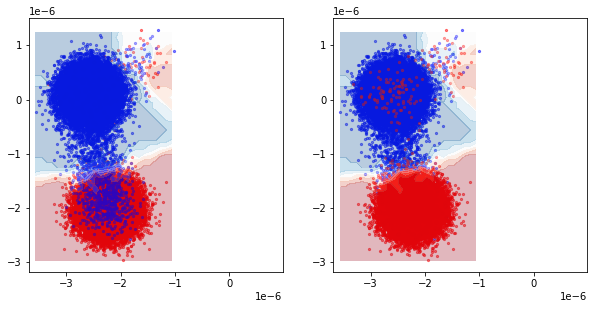

{'duration': 11200, 'amp_mul': 1.8, 'qubit': 3}
0.9845833333333334


<Figure size 432x288 with 0 Axes>

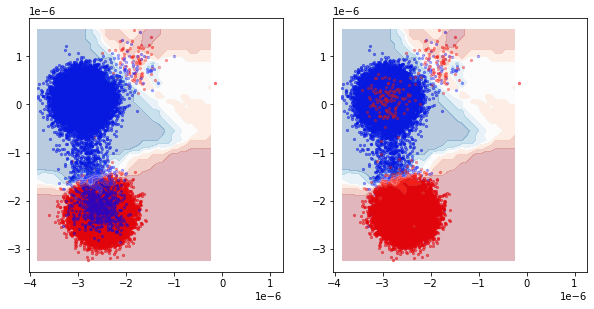

{'duration': 11200, 'amp_mul': 2.0, 'qubit': 3}
0.9861


<Figure size 432x288 with 0 Axes>

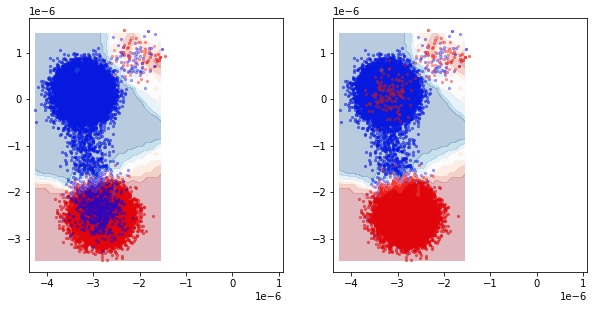

{'duration': 11200, 'amp_mul': 2.2, 'qubit': 3}
0.9877


<Figure size 432x288 with 0 Axes>

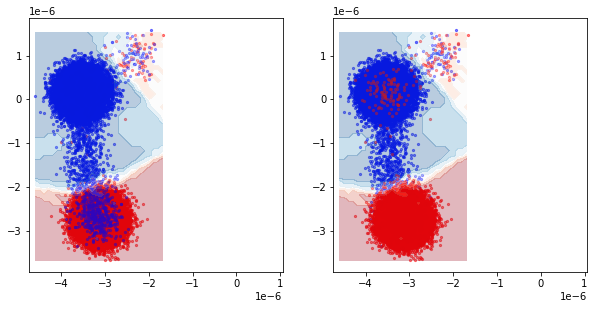

In [305]:
import sklearn
from sklearn.neighbors import KNeighborsClassifier

for job_idx, job in enumerate(jobs):
    gnd_results = job.result().get_memory(0)[:,experiments[job_idx]['qubit']]*scale_factor
    exc_results = job.result().get_memory(1)[:,experiments[job_idx]['qubit']]*scale_factor

    gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
    exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])

    x = np.concatenate([gnd_results, exc_results])
    y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[1].axis('square')

    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))

    classifier = KNeighborsClassifier(10)
    classifier.fit(x,y)
    score = classifier.score(x, y)
    print(experiments[job_idx])
    print(score)

    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    plt.show()


{'duration': 22400, 'amp_mul': 1.0}
0.9790833333333333


<Figure size 432x288 with 0 Axes>

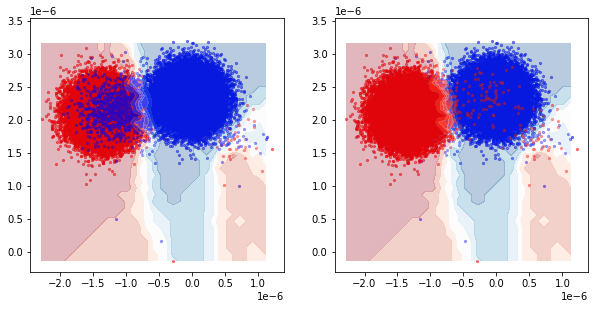

{'duration': 22400, 'amp_mul': 1.2}
0.9826666666666667


<Figure size 432x288 with 0 Axes>

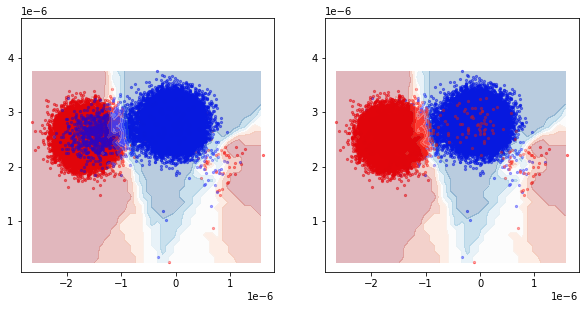

{'duration': 22400, 'amp_mul': 1.4}
0.9834666666666667


<Figure size 432x288 with 0 Axes>

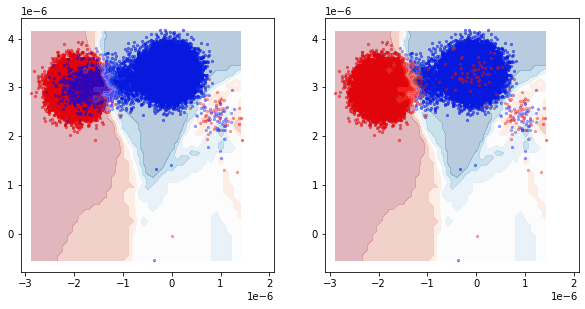

{'duration': 22400, 'amp_mul': 1.6}
0.9849333333333333


<Figure size 432x288 with 0 Axes>

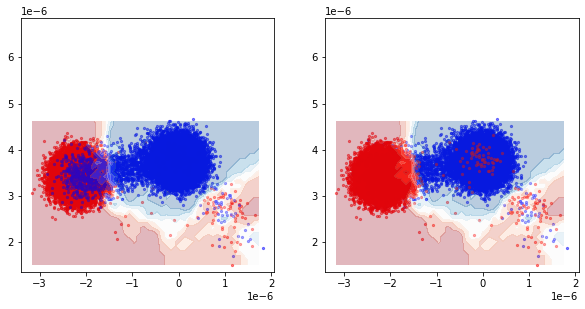

{'duration': 22400, 'amp_mul': 1.8}
0.9875333333333334


<Figure size 432x288 with 0 Axes>

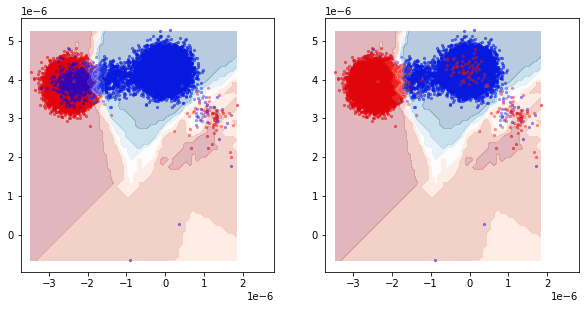

{'duration': 22400, 'amp_mul': 2.0}
0.9878833333333333


<Figure size 432x288 with 0 Axes>

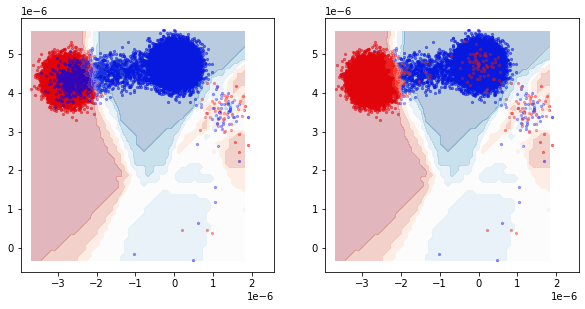

{'duration': 22400, 'amp_mul': 2.2}
0.9885833333333334


<Figure size 432x288 with 0 Axes>

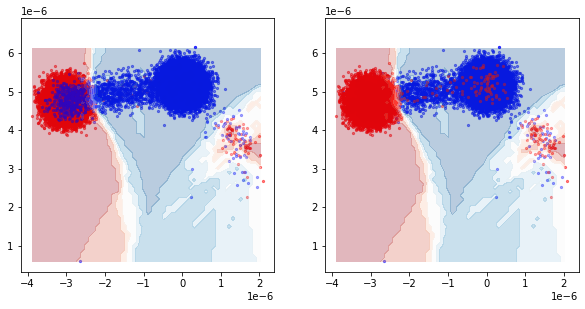

{'duration': 11200, 'amp_mul': 1.0}
0.9335166666666667


<Figure size 432x288 with 0 Axes>

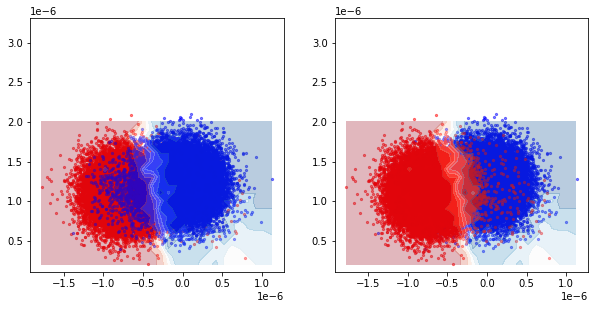

{'duration': 11200, 'amp_mul': 1.2}
0.9660166666666666


<Figure size 432x288 with 0 Axes>

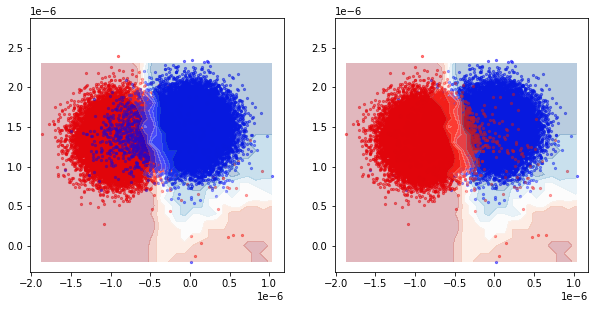

{'duration': 11200, 'amp_mul': 1.4}
0.9745833333333334


<Figure size 432x288 with 0 Axes>

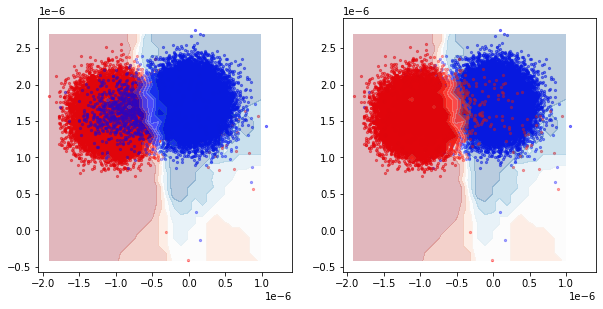

{'duration': 11200, 'amp_mul': 1.6}
0.9816666666666667


<Figure size 432x288 with 0 Axes>

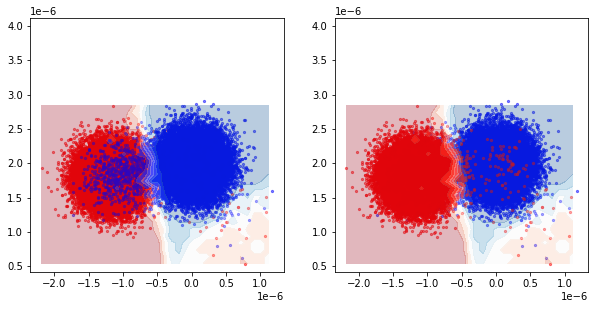

{'duration': 11200, 'amp_mul': 1.8}
0.9866333333333334


<Figure size 432x288 with 0 Axes>

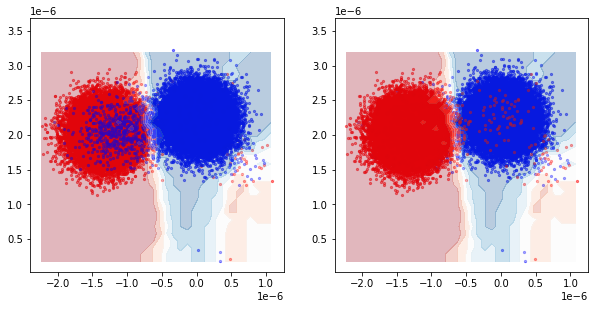

{'duration': 11200, 'amp_mul': 2.0}
0.98805


<Figure size 432x288 with 0 Axes>

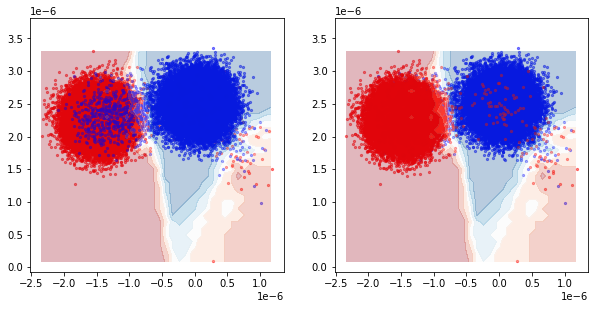

{'duration': 11200, 'amp_mul': 2.2}
0.98885


<Figure size 432x288 with 0 Axes>

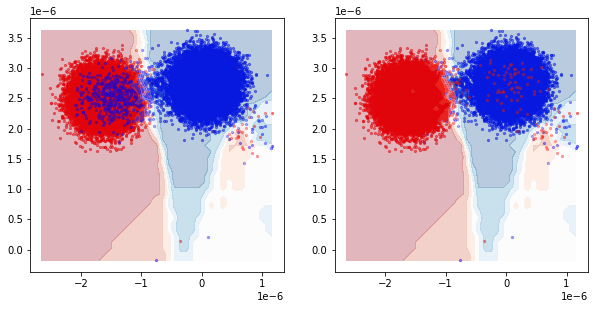

In [292]:
# qubit = 1

import sklearn
from sklearn.neighbors import KNeighborsClassifier

for job_idx, job in enumerate(jobs):   
    gnd_results = job.result().get_memory(0)[:,1]*scale_factor
    exc_results = job.result().get_memory(1)[:,1]*scale_factor
    
    gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
    exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])
    
    x = np.concatenate([gnd_results, exc_results])
    y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[1].axis('square')
    
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))
    
    classifier = KNeighborsClassifier(10)
    classifier.fit(x,y)
    score = classifier.score(x, y)
    print(experiments[job_idx])
    print(score)
    
    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)    
    plt.show()


0.9834


<Figure size 432x288 with 0 Axes>

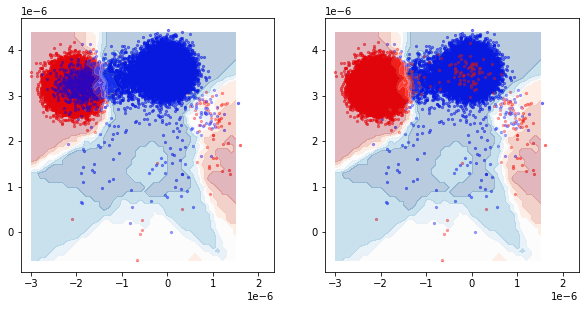

0.98815


<Figure size 432x288 with 0 Axes>

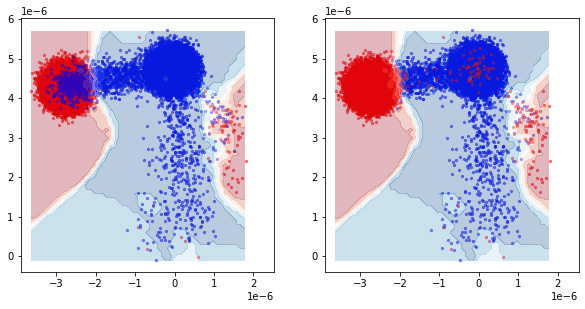

In [288]:
# if i_ == 0:
#         duration_ = int(22400)
#         amp_mul_ = 1.5
#     elif i_ == 1:
#         duration_= int(22400)
#         amp_mul_ = 2.0

import sklearn
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(10)

for job_idx, job in enumerate(jobs):
    gnd_results = job.result().get_memory(0)[:,1]*scale_factor
    exc_results = job.result().get_memory(1)[:,1]*scale_factor
    
    gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
    exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])
    
    x = np.concatenate([gnd_results, exc_results])
    y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[1].axis('square')
    
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))
    
    classifier.fit(x,y)
    score = classifier.score(x, y)
    print(experiments[job_idx])
    print(score)
    
    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)    
    plt.show()


0.9799333333333333


<Figure size 432x288 with 0 Axes>

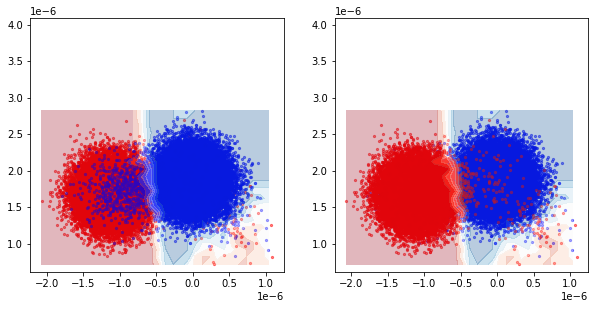

0.9875833333333334


<Figure size 432x288 with 0 Axes>

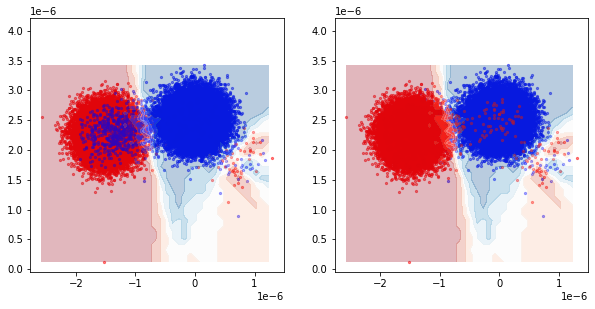

In [286]:
# if i_ == 0:
#         duration_ = int(22400/2)
#         amp_mul_ = 1.5
#     elif i_ == 1:
#         duration_= int(22400/2)
#         amp_mul_ = 2.0

import sklearn
# from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
classifier = KNeighborsClassifier(10)
# classifier = SVC(kernel="linear", C=0.025)
# classifier = DecisionTreeClassifier(max_depth=5)
# classifier = MLPClassifier(alpha=1, max_iter=1000)

for job in jobs:
    gnd_results = job.result().get_memory(0)[:,1]*scale_factor
    exc_results = job.result().get_memory(1)[:,1]*scale_factor
    
    gnd_results = np.array([[np.real(x), np.imag(x)] for x in gnd_results])
    exc_results = np.array([[np.real(x), np.imag(x)] for x in exc_results])
    
    x = np.concatenate([gnd_results, exc_results])
    y = np.array([0]*len(gnd_results)+[1]*len(exc_results))
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[0].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(exc_results[:, 0], exc_results[:, 1], s=5, cmap='viridis', c='blue', alpha=0.5, label='state_1')
    axs[1].scatter(gnd_results[:, 0], gnd_results[:, 1], s=5, cmap='viridis', c='red', alpha=0.5, label='state_0')
    axs[1].axis('square')
    
    x_min, x_max = x[:, 0].min(), x[:, 0].max()
    y_min, y_max = x[:, 1].min(), x[:, 1].max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 1e-6/10), np.arange(y_min, y_max, 1e-6/10))
    
    classifier.fit(x,y)
    score = classifier.score(x, y)
    print(score)
    
    # pred = classifier.predict_proba(x)[:, 1]
    # print(pred)
    # correct = 0
    # total = float(len(pred))
    # for idx in range(len(pred)):
    #     if round(pred[idx]) == y[idx]:
    #         correct += 1
    # print(correct/total)
    
    if hasattr(classifier, "decision_function"):
        Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    axs[0].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)
    axs[1].contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.3)    
    plt.show()


<Figure size 432x288 with 0 Axes>

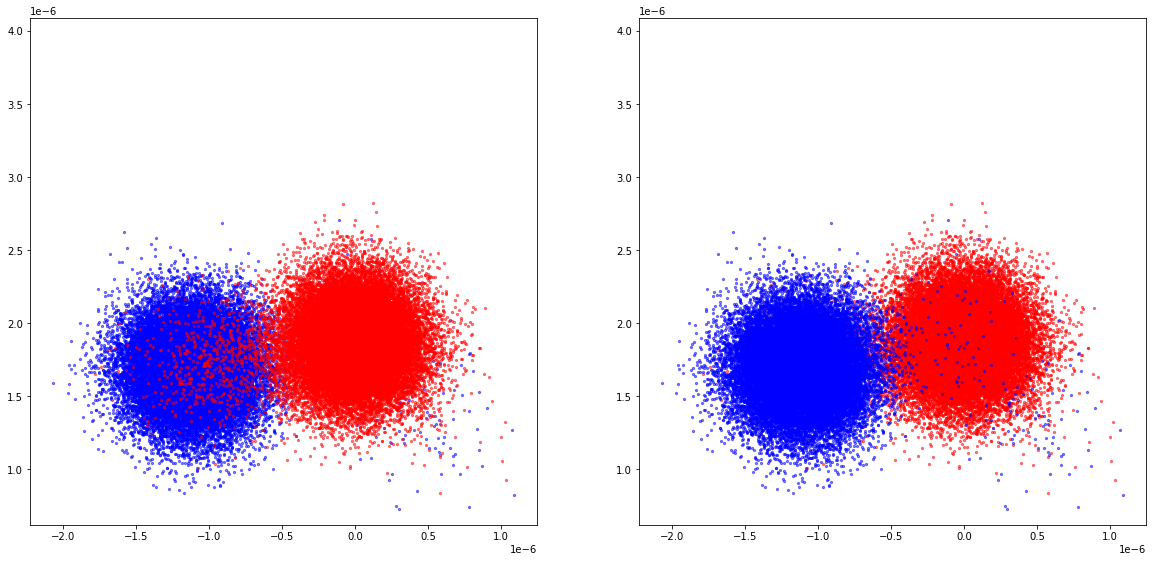

<Figure size 432x288 with 0 Axes>

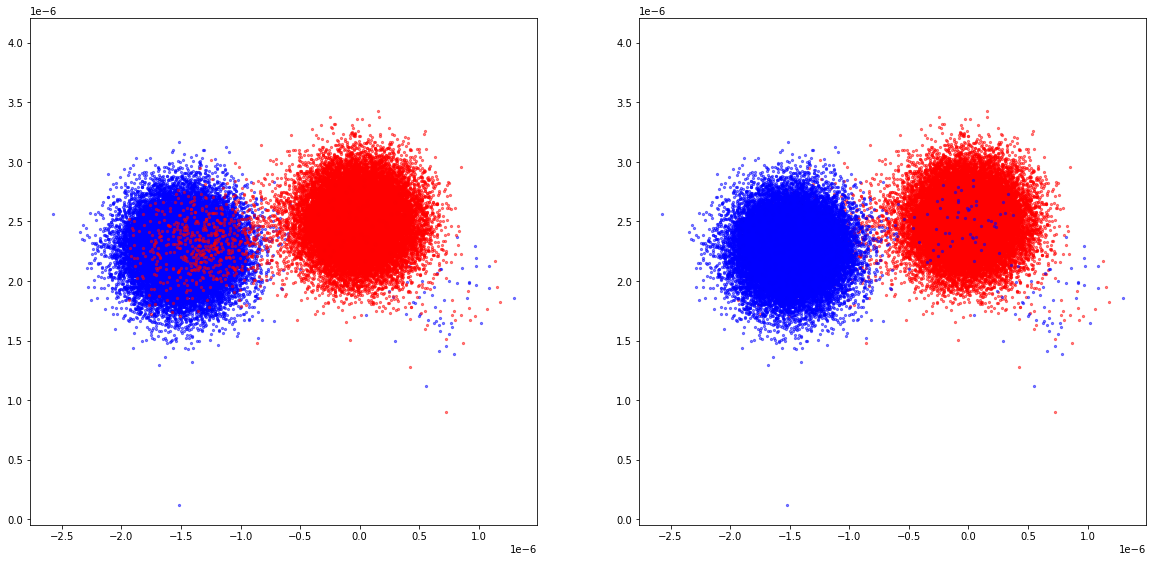

In [224]:
# if i_ == 0:
#         duration_ = int(22400/2)
#         amp_mul_ = 1.5
#     elif i_ == 1:
#         duration_= int(22400/2)
#         amp_mul_ = 2.0

for job in jobs:
    gnd_results = job.result().get_memory(0)[:,1]*scale_factor
    exc_results = job.result().get_memory(1)[:,1]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


<Figure size 432x288 with 0 Axes>

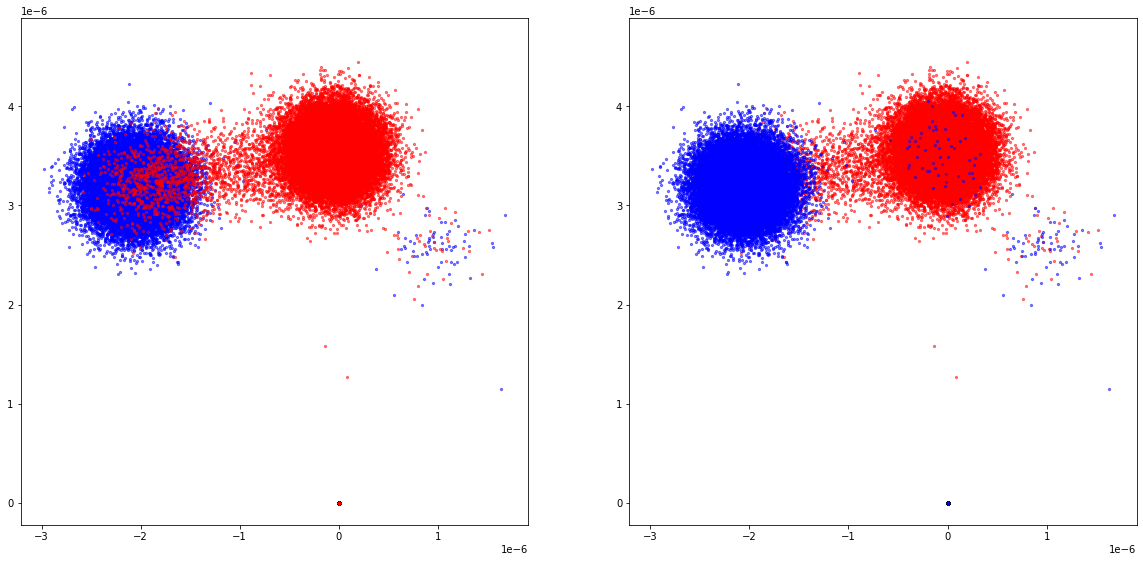

<Figure size 432x288 with 0 Axes>

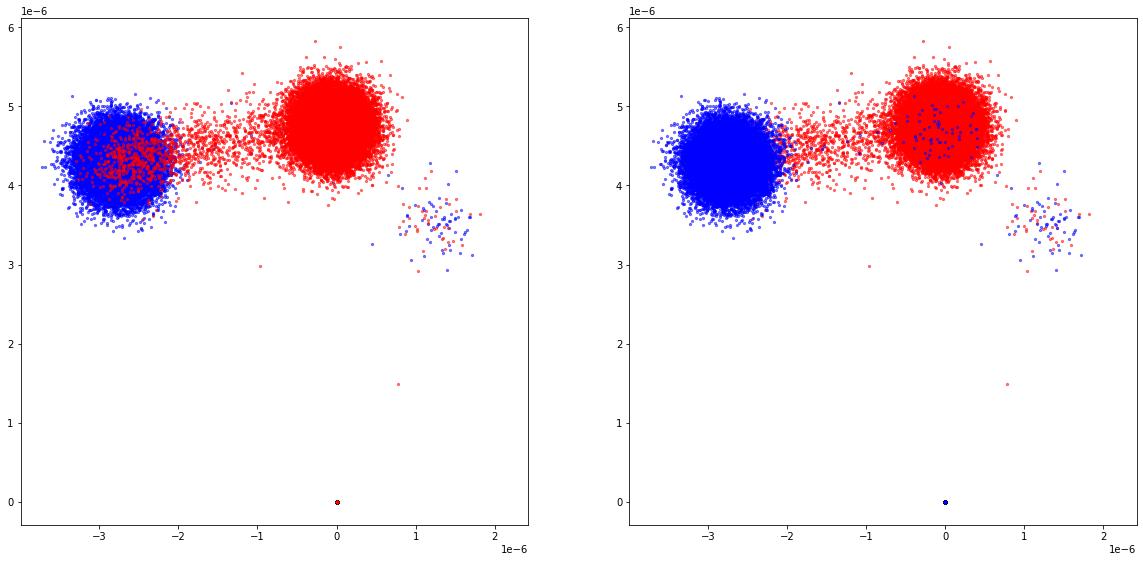

In [201]:
# if i_ == 0:
#         duration_ = 22400
#         amp_mul_ = 1.5
#     elif i_ == 1:
#         duration_= 22400
#         amp_mul_ = 2.0

scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


<Figure size 432x288 with 0 Axes>

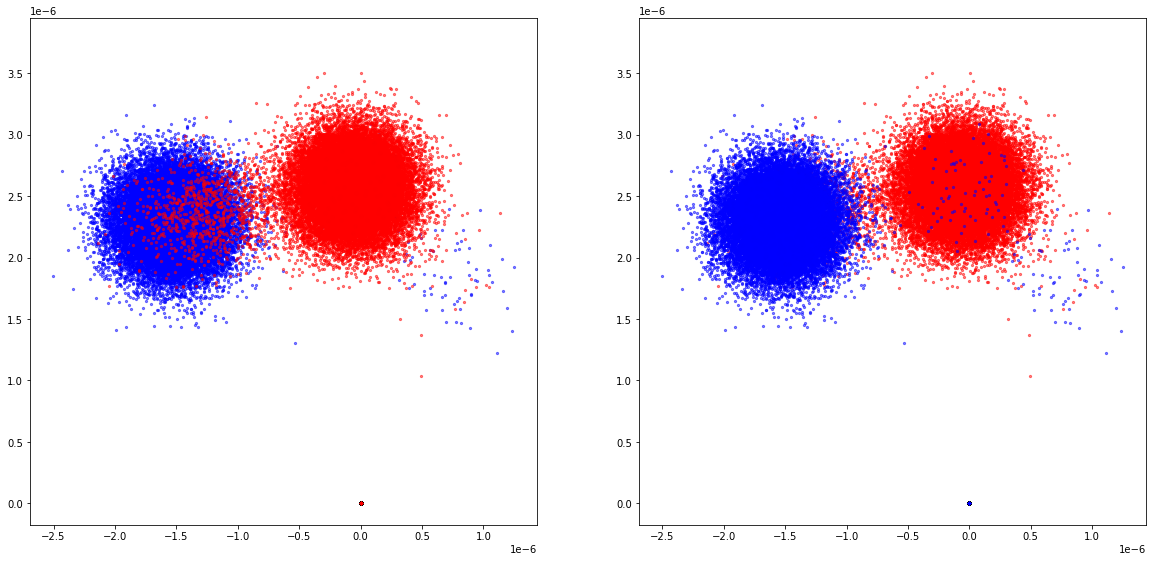

<Figure size 432x288 with 0 Axes>

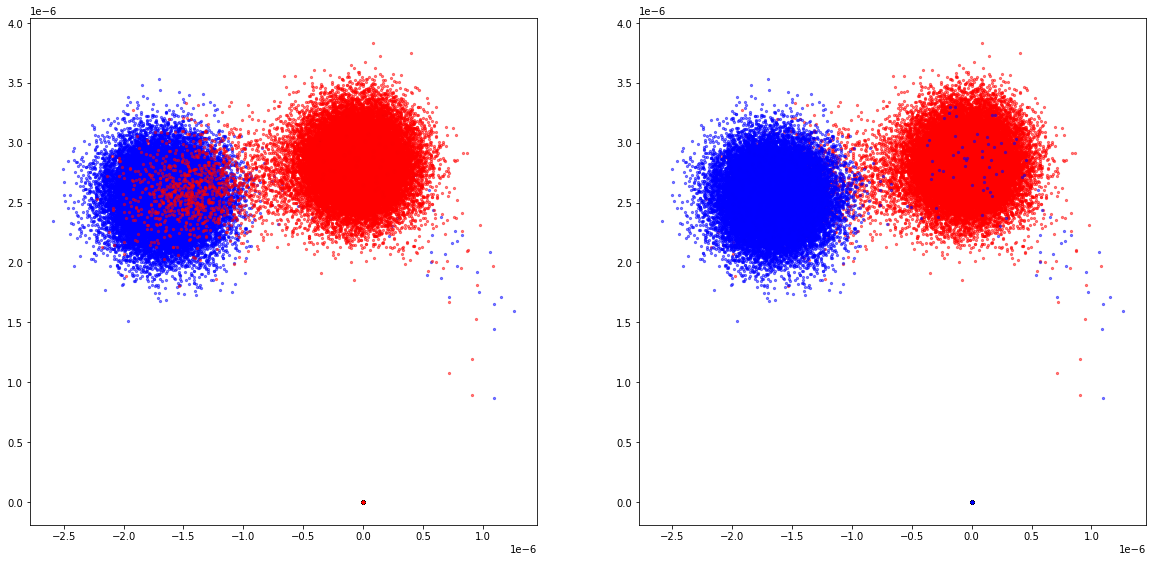

In [199]:
    # if i_ == 0:
    #     duration_ = 22400
    #     amp_mul_ = 1.1
    # elif i_ == 1:
    #     duration_= 22400
    #     amp_mul_ = 1.2

scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


<Figure size 432x288 with 0 Axes>

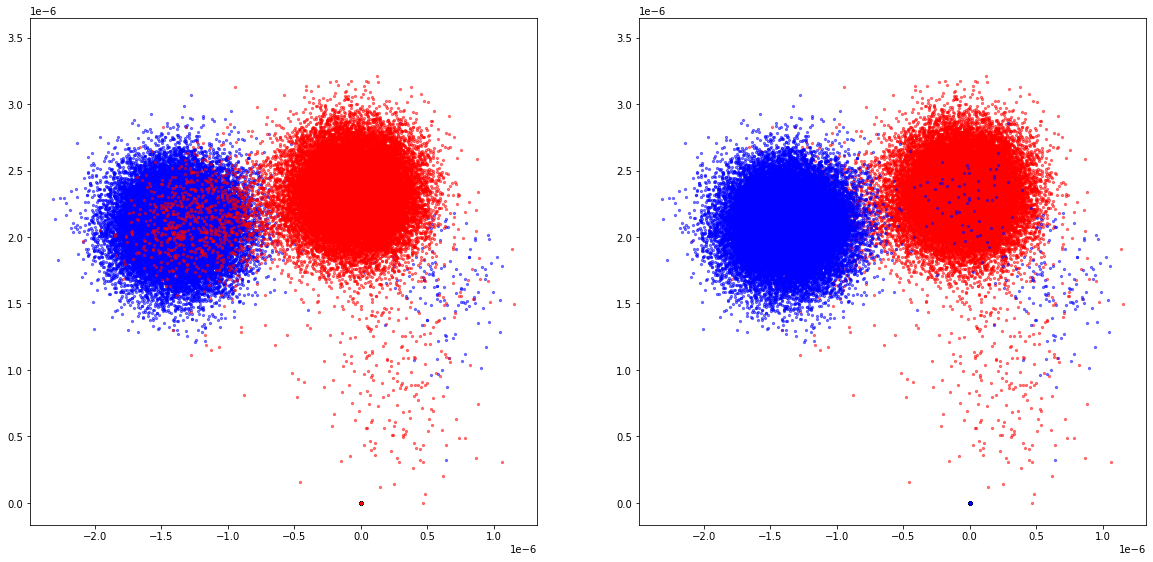

<Figure size 432x288 with 0 Axes>

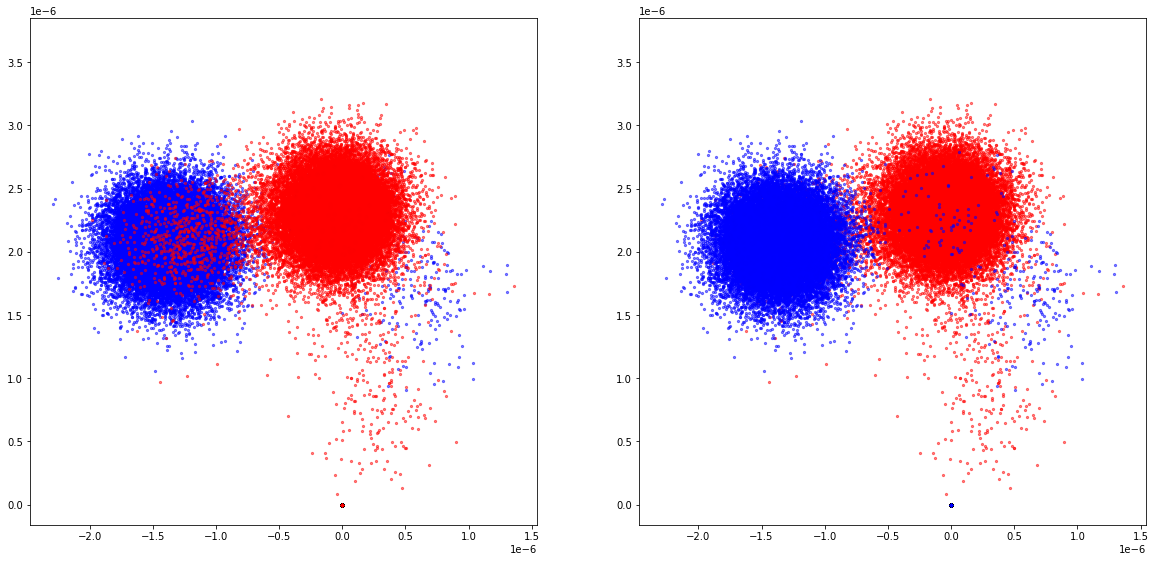

In [188]:
# if i_ == 0:
        # duration_ = 22400*2
    # elif i_ == 1:
        # duration_= 22400*3

scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


<Figure size 432x288 with 0 Axes>

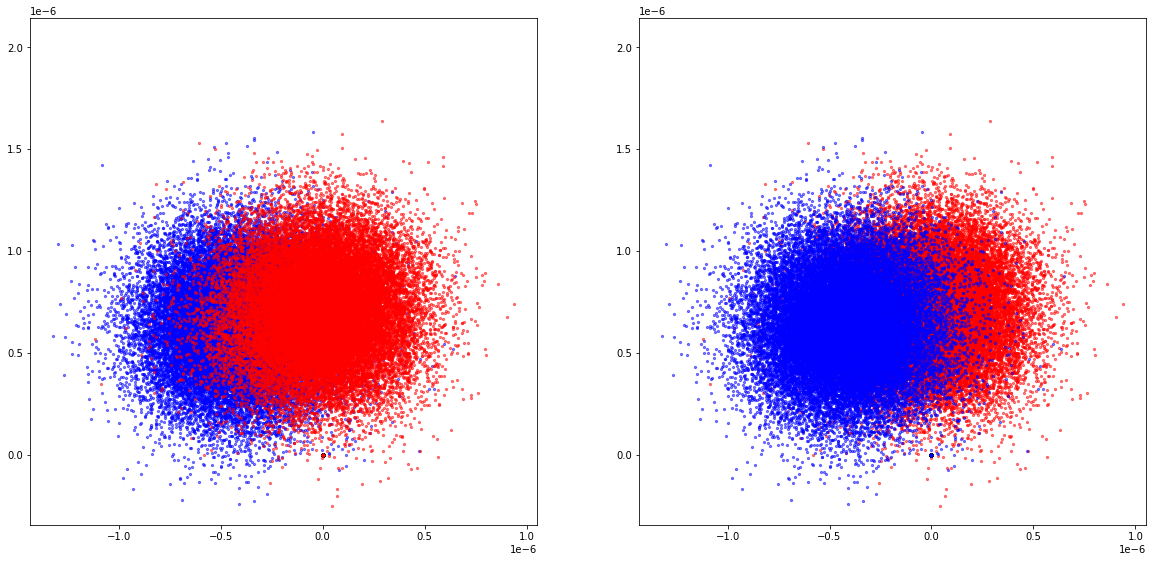

<Figure size 432x288 with 0 Axes>

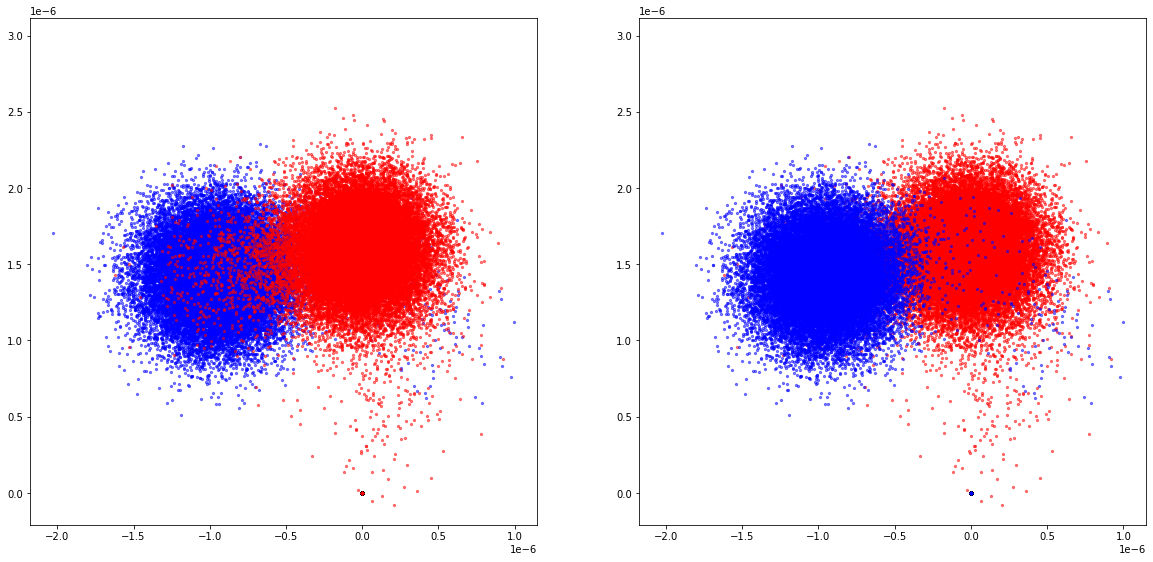

In [186]:
#    if i_ == 0:
#        duration_ = 22400-1000*16
#    elif i_ == 1:
#        duration_= 22400-500*16

scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


<Figure size 432x288 with 0 Axes>

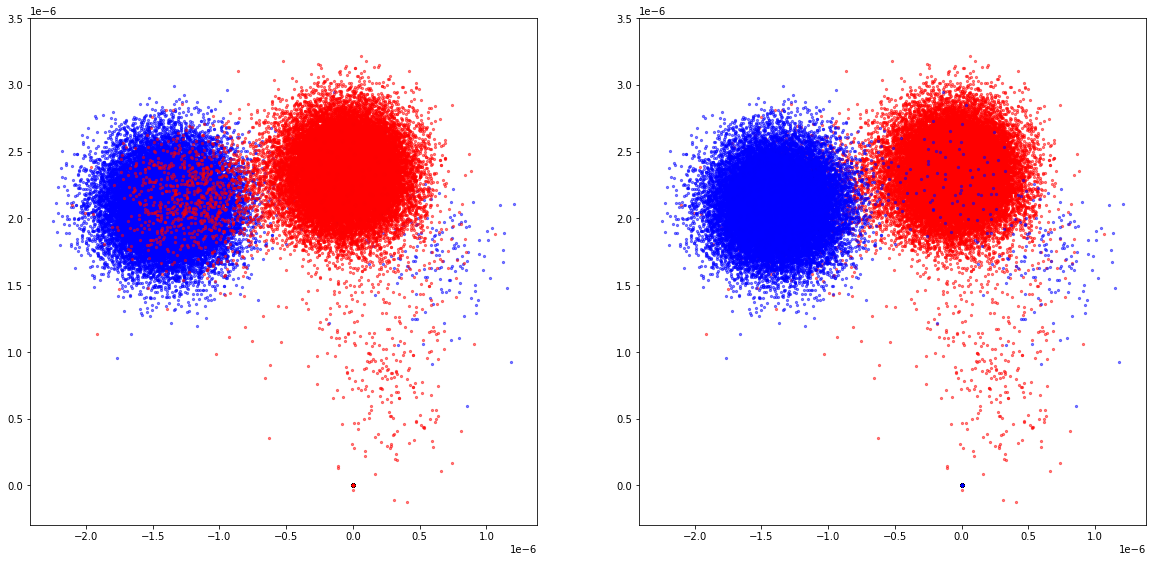

<Figure size 432x288 with 0 Axes>

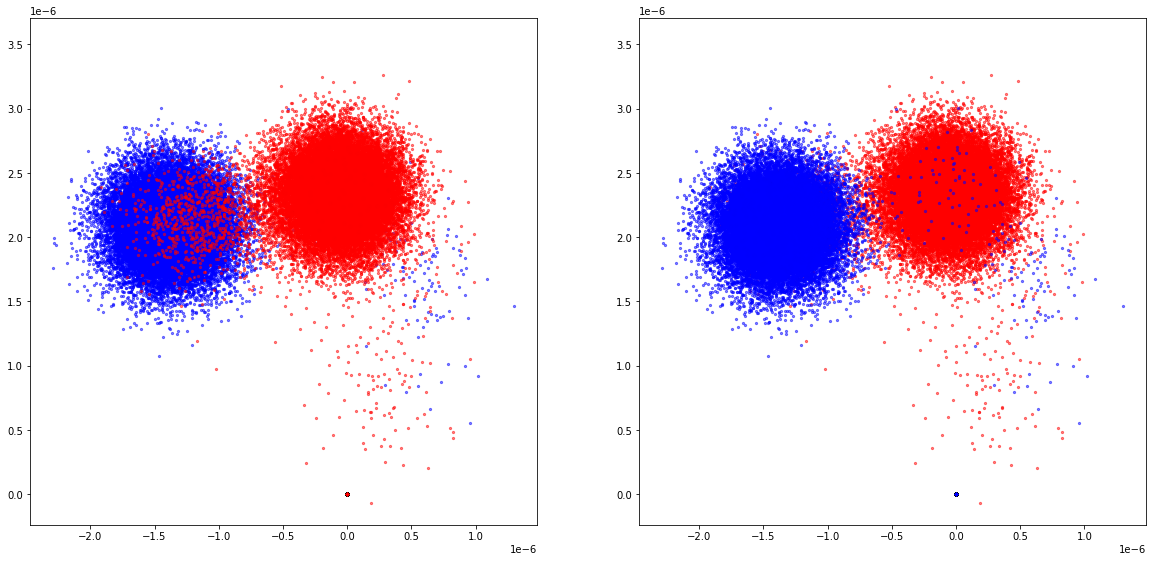

In [184]:
# default
# 22400+500*16

scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


### Measurement duration and frequency check

In [36]:
qc_gnd = measurement_circuit([1,3,5], final_state='gnd', delay=1000)
qc_ext = measurement_circuit([1,3,5], final_state='ext', delay=1000)
jobs = []
circuits = []


schedule_gnd = build_schedule(qc_gnd, backend, method='alap')
schedule_ext = build_schedule(qc_ext, backend, method='alap')
job = execute([schedule_gnd, schedule_ext], backend, meas_level=1, meas_return='single', memory=True, shots=30000, optimization_level=0)
circuits.append(qc)
job_monitor(job)
jobs.append(job)

Job Status: job has successfully run


<Figure size 432x288 with 0 Axes>

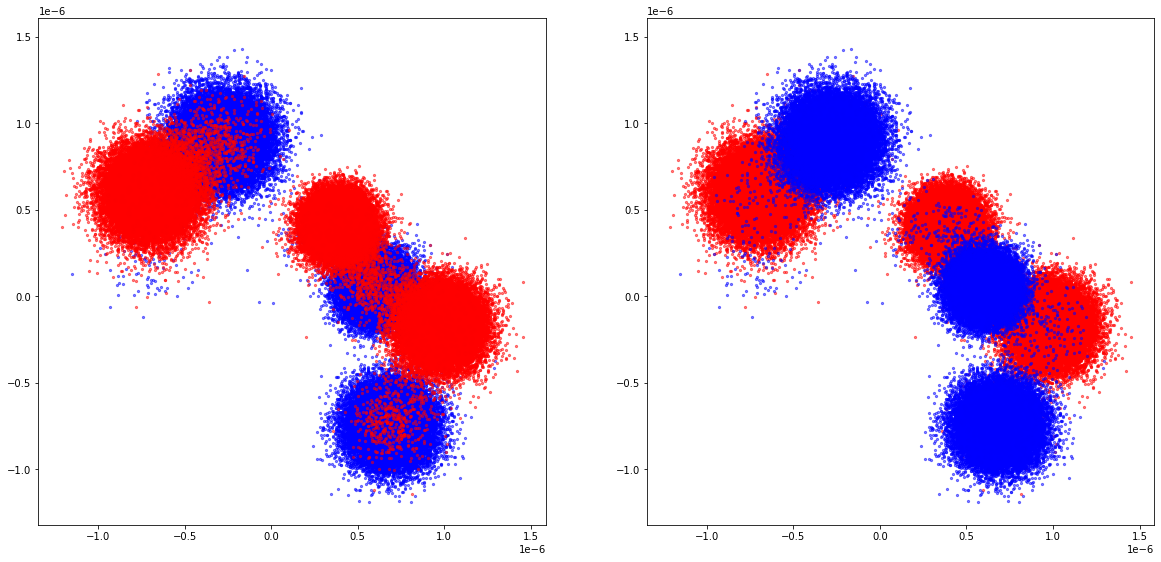

In [37]:
scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


In [46]:
qc_gnd = measurement_circuit([1,3,5], final_state='gnd', delay=800)
qc_ext = measurement_circuit([1,3,5], final_state='ext', delay=800)
jobs = []
circuits = []


schedule_gnd = build_schedule(qc_gnd, backend, method='alap')
schedule_ext = build_schedule(qc_ext, backend, method='alap')
job = execute([schedule_gnd, schedule_ext], backend, meas_level=1, meas_return='single', memory=True, shots=30000, optimization_level=0)
circuits.append(qc)
job_monitor(job)
jobs.append(job)

Job Status: job has successfully run


<Figure size 432x288 with 0 Axes>

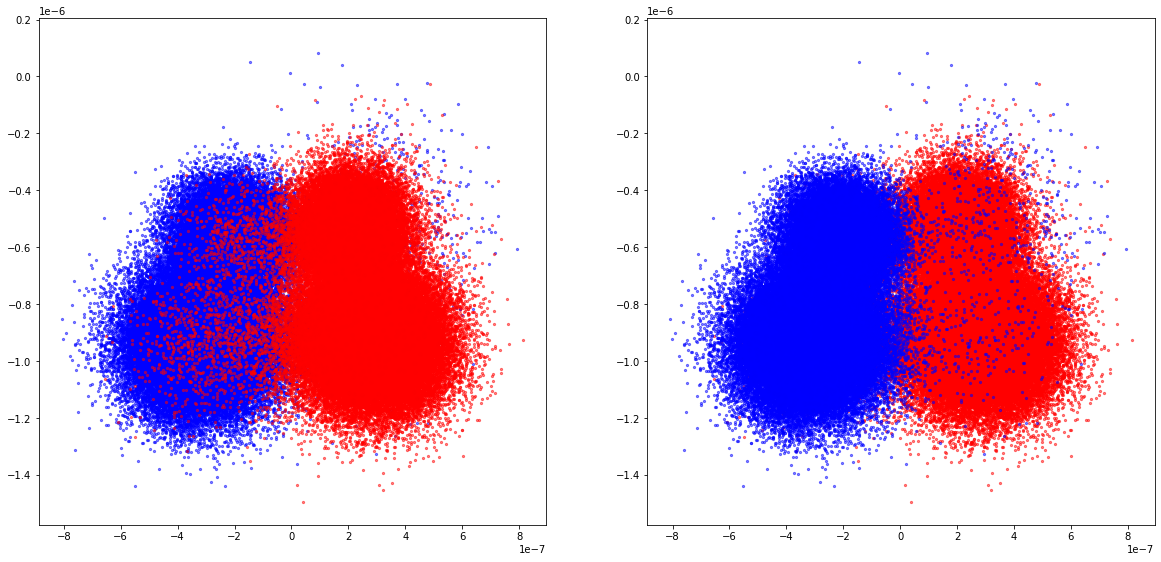

In [47]:
scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()


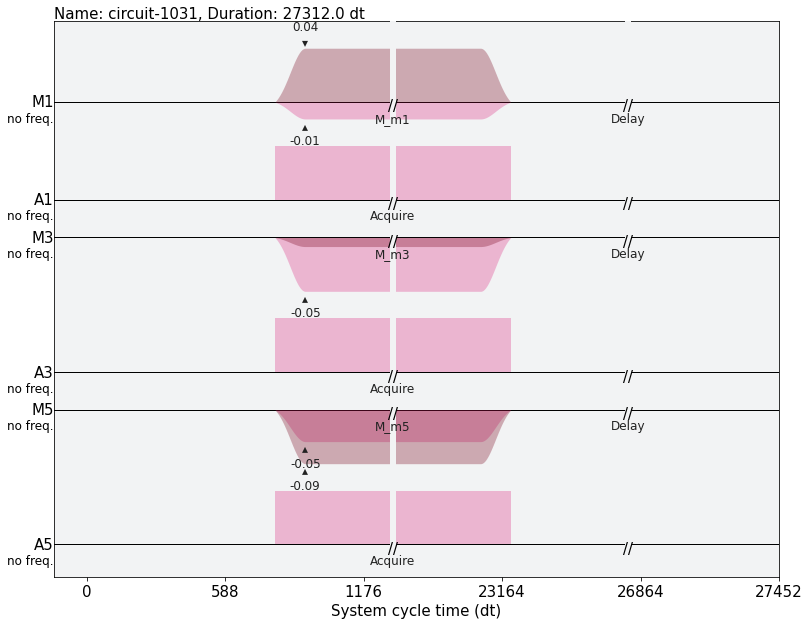

In [60]:
schedule_gnd.draw(style=IQXDebugging())

In [57]:
print(schedule_ext)

Schedule((0, Play(Drag(duration=160, amp=(0.18563075606776788+0j), sigma=40, beta=-0.5737006695352255, name='Xp_d1'), DriveChannel(1), name='Xp_d1')), (0, Play(Drag(duration=160, amp=(0.11059572745482073+0j), sigma=40, beta=-1.6050525302754728, name='Xp_d3'), DriveChannel(3), name='Xp_d3')), (0, Play(Drag(duration=160, amp=(0.17504552731940665+0j), sigma=40, beta=0.4794770518166238, name='Xp_d5'), DriveChannel(5), name='Xp_d5')), (160, Delay(800, DriveChannel(1))), (160, Delay(800, DriveChannel(3))), (160, Delay(800, DriveChannel(5))), (960, Acquire(22400, AcquireChannel(1), MemorySlot(0))), (960, Acquire(22400, AcquireChannel(3), MemorySlot(1))), (960, Acquire(22400, AcquireChannel(5), MemorySlot(2))), (960, Play(GaussianSquare(duration=22400, amp=(-0.013725908097804792+0.04390443538972591j), sigma=64, width=22144, name='M_m1'), MeasureChannel(1), name='M_m1')), (960, Play(GaussianSquare(duration=22400, amp=(-0.04930050692311275-0.008334267641737466j), sigma=64, width=22144, name='M_m

In [85]:
meas_los_freq = [x*1.00001 for x in backend.defaults().meas_freq_est]
meas_los_freq

[7284127503.546631,
 7385524048.501941,
 7323253261.800301,
 7230828724.564171,
 7280383666.10863,
 7147064842.93373,
 7400726540.52534]

In [86]:
qc_gnd = measurement_circuit([1], final_state='gnd', delay=0)
qc_ext = measurement_circuit([1], final_state='ext', delay=0)
jobs = []
circuits = []

for _ in range(2):
    schedule_gnd = build_schedule(qc_gnd, backend, method='alap')
    schedule_ext = build_schedule(qc_ext, backend, method='alap')
    job = execute([schedule_gnd, schedule_ext], backend, meas_level=1, meas_return='single', memory=True, shots=30000, optimization_level=0, default_meas_los=meas_los_freq)
    circuits.append(qc)
    job_monitor(job)
    jobs.append(job)

Job Status: job has successfully run
Job Status: job has successfully run


<Figure size 432x288 with 0 Axes>

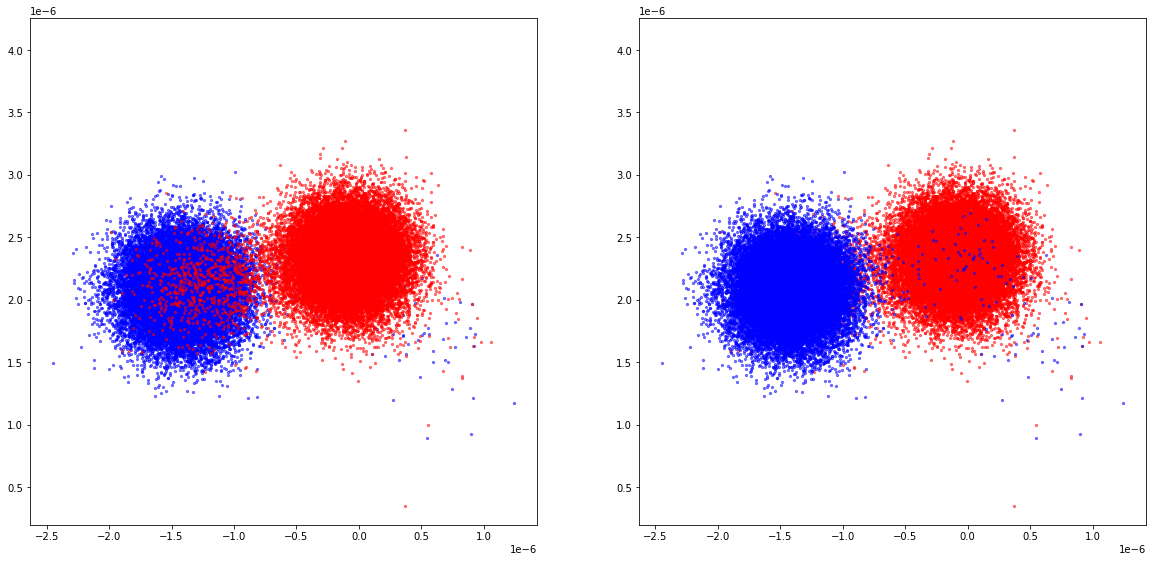

<Figure size 432x288 with 0 Axes>

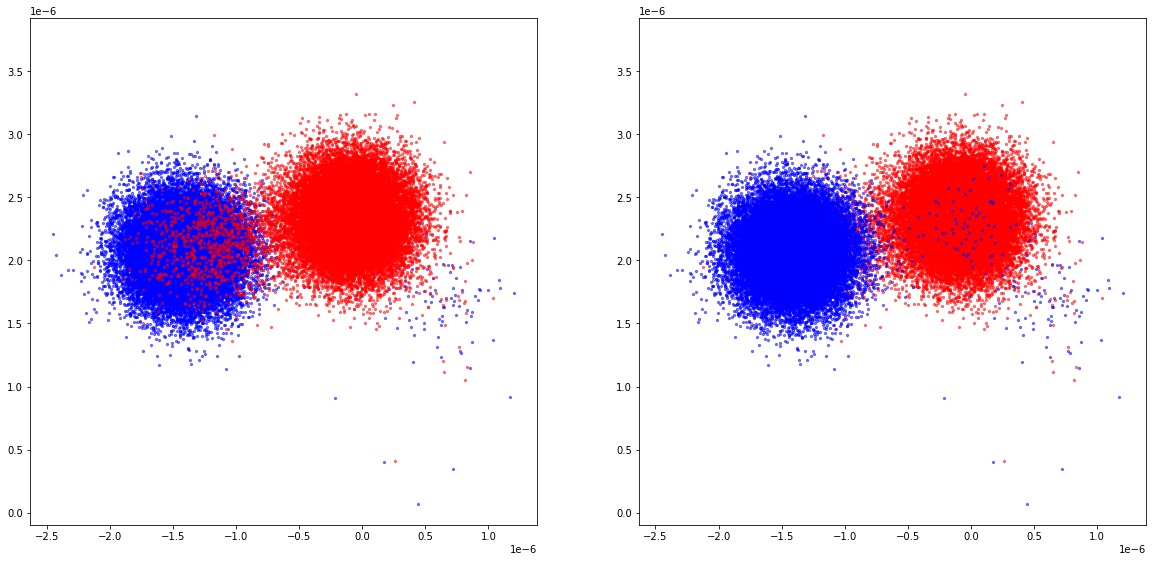

In [87]:
scale_factor = 1e-14

for job in jobs:
    gnd_results = job.result().get_memory(0)[:]*scale_factor
    exc_results = job.result().get_memory(1)[:]*scale_factor
    
    plt.figure()
    fig, axs = plt.subplots(1, 2, figsize=(20, 20))
    # Plot all the results
    # All results from the gnd_schedule are plotted in blue
    axs[0].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    # All results from the exc_schedule are plotted in red
    axs[0].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[0].axis('square')

    axs[1].scatter(np.real(exc_results), np.imag(exc_results), 
                    s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
    axs[1].scatter(np.real(gnd_results), np.imag(gnd_results), 
                    s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
    axs[1].axis('square')
    plt.show()
